In [148]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dask import delayed
import seaborn as sns
import glob
from time import time
sns.set(style='whitegrid',font_scale=1.3,context='talk')

In [217]:
# read grid
path = './output_2013asiri_06b/'
zgrid = pd.read_csv(path+'zgrid.out', skipinitialspace=True, sep=' ', header=None)[1][1:51].astype(float)
dz,dy,dx = np.meshgrid(np.diff(zgrid), np.diff(ds.y*1000),np.diff(ds.x*1000), indexing='ij')
jac =  dy*dx*dz

In [223]:
@delayed
def kinetic_energy(ds):
    '''subsampled kinetic energy'''
    return np.sum ( (jac[::2,::2,::2]/3)*(ds.u[1::2,1::2,1::2]**2+ds.v[1::2,1::2,1::2]**2+(ds.w[1::2,1::2,1::2]*1e-3)**2))

def ts_to_days(timestep,sec_per_timestep=288):
    return timestep*sec_per_timestep/86400

In [235]:
# workflow to lazily compute KE
#start = time()
end = np.int( glob.glob('./output_2013asiri_06b/full_*.cdf')[-1][-9:-4] )
template = './output_2013asiri_06b/full_{:05d}.cdf'
filenames = (template.format(k) for k in range(0,end,100))
datasets = (xr.open_dataset(fname) for fname in filenames)
totals = [kinetic_energy(ds) for ds in datasets]
ke = [item.compute() for item in totals]
ke = np.array( ke )
#print((time()-start)/60)

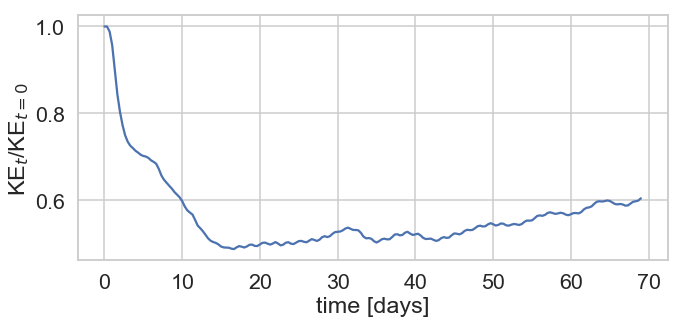

In [236]:
plt.figure(figsize=(10,5))
plt.plot(ts_to_days(np.arange(0,end,100)),ke/ke[0])
plt.xlabel('time [days]')
plt.ylabel(r'KE$_t$/KE$_{t=0}$')
plt.tight_layout()
plt.savefig('ke_timeseries_06_%d.pdf' %end,bb_inches='tight')
plt.show()

In [ ]:
f,(ax1,ax2) = plt.subplots(2,1,figsize=(15,10),sharex=True)

ax1.plot(ts_to_days(np.arange(0,end,100)),ke/ke[0])
ax2.plot(ts_to_days(np.arange(0,end,100)),(mld))